## Preamble


In [3]:
%cd /Users/kostastsampourakis/Desktop/code/Python/projects/BayesianFiltering
import codebase.utils as utils
import codebase.gaussfilt as gf
import numpy as np
from jax import numpy as jnp
from numpy import random
import matplotlib.pyplot as plt
import codebase.gausssumfilt as gsf
import pandas as pd
import codebase.particlefilt as pf
import time

/Users/kostastsampourakis/Desktop/code/Python/projects/BayesianFiltering


## Experiment

In [21]:
# Parameters
dx = 1
dy = 1
seq_length = 100
# m0_sim = np.array([0.0, 1.0, 1.05])
m0_sim = np.array([0.0])
m0 = np.zeros(dx)
P0 = 1 * np.eye(dx)
c = np.zeros(dx)
d = np.zeros(dy)
Q = 0.1 * np.eye(dx)
R = 0.0001 * np.eye(dy)

## Define nonlinearity
##############################################################  1 Polynomial
A = 0.8 * np.eye(dx)

# f = lambda x: 1 * (-1/2 + 1 / (1 + jnp.exp(-4*x)))
# f = lambda x: jnp.array([x[0] + jnp.sin(x[1]), 0.9 * x[0]])
# f = lambda x: 0.5 * x + 25 * x / (1+x**2)
# f = lambda x: x
# r = 3.44940
# f = lambda x: jnp.array([max(r*x*(1-x), 1.0)])
# f = lambda x: jnp.sin(jnp.array([10 * x[0]**2 + x[1], x[0]*x[1]])) #* jnp.exp(-x**2 / 10)
f = lambda x: 0.8*x
# Lorenz
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])

##############################################################  4
# g = lambda x: 0.1 * jnp.array([jnp.dot(x, x)])
g = lambda x: 0.1 * jnp.array([x**2])
# g1 = lambda x: x
# g2 = lambda x: jnp.sin(x)
# g = lambda x: jnp.piecewise(x, [x < 0.1, x >= 0.1], [g1, g2])

###############################################################

verbose = False
Nsim = 1
ekf_rmse = np.zeros(Nsim)
gsf_rmse = np.zeros(Nsim)
agsf_rmse = np.zeros(Nsim)
ekf_time = np.zeros(Nsim)
gsf_time = np.zeros(Nsim)
agsf_time = np.zeros(Nsim)
bpf_rmse = np.zeros(Nsim)
bpf_time = np.zeros(Nsim)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    ssm = gf.SSM(dx, dy, c=c, Q=Q, d=d, R=R, f=f, g=g)
    xs, ys = ssm.simulate(seq_length, m0_sim)

    # Ground Truth
    # num_prt_gt = 1000
    # gt = pf.BootstrapPF(ssm, num_prt_gt)
    # gt_out = gt.run(ys, m0, P0, verbose=verbose)
    # gt_mean = np.sum(gt_out[:seq_length], 1) / num_prt_gt
    gt_mean = xs

    # Gaussian Sum filter
    # M0 = 10
    # gsf1 = gsf.GaussSumFilt(ssm, M=M0)
    # gsf_out = gsf1.run(ys, m0, P0, verbose=verbose)

    # Extended Kalman Filter
    ekf = gf.EKF(ssm, order=1)
    ekf_out = ekf.run(ys, m0, P0, verbose=verbose)

    # Bootstrap Particle Filter
    num_prt = 100
    bpf = pf.BootstrapPF(ssm, num_prt)
    bpf_out = bpf.run(ys, m0, P0, verbose=verbose)
    bpf_mean = np.sum(bpf_out[:seq_length], 1) / num_prt

    # Augmented Gaussian Sum filter
    M = 3
    N = 2
    L = 2
    AGSF = gsf.AugGaussSumFilt(ssm, M, N, L)
    AGSF.set_aug_selection_params(1.0, 0.5, a='prop', b='prop') # options are ['prop', 'opt_lip', 'opt_max_grad', 'input', 'test'] e.g. a='opt_max_grad', b='opt_max_grad'
    agsf_out = AGSF.run(ys, m0, P0, verbose=verbose)

    # Computation of errors
    ekf_rmse[i] = utils.rmse(ekf_out[1], gt_mean)
    ekf_time[i] = ekf.time
    # gsf_rmse[i] = utils.rmse(gsf_out[3], gt_mean)
    # gsf_time[i] = gsf1.time
    agsf_rmse[i] = utils.rmse(agsf_out[2], gt_mean)
    agsf_time[i] = AGSF.time
    bpf_rmse[i] = utils.rmse(bpf_mean, gt_mean)
    bpf_time[i] = bpf.time

    print('EKF RMSE:', ekf_rmse[i])
    print('EKF time:', ekf_time[i])
    # print('GSF RMSE:', gsf_rmse[i])
    # print('GSF time:', gsf_time[i])
    print('AGSF RMSE:', agsf_rmse[i])
    print('AGSF time:', agsf_time[i])
    print('BPF RMSE:', bpf_rmse[i])
    print('BPF time:', bpf_time[i])

sim 1/1
EKF RMSE: 0.45951756004149946
EKF time: 2.3291051387786865
AGSF RMSE: 0.7109398335579689
AGSF time: 1.8115007877349854
BPF RMSE: 0.6527131162016537
BPF time: 14.613029956817627


## 1D plots

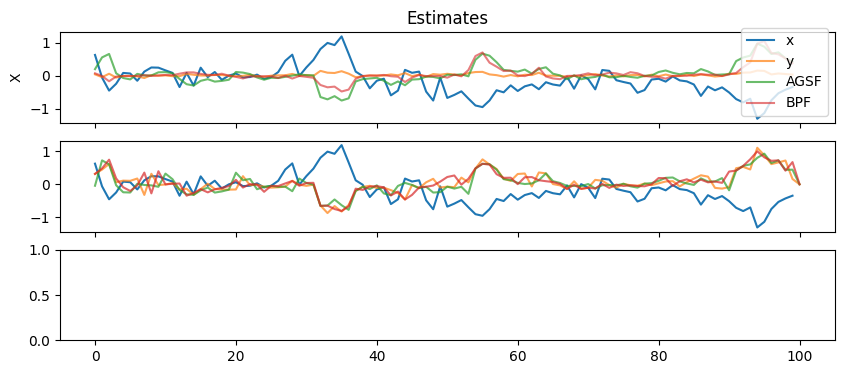

In [22]:
fig1, axes1 = plt.subplots(3, 1, sharex=True, figsize=(10, 4))
axes1[0].plot(xs[:, 0], alpha=1, label="xs")
axes1[0].plot(ys, alpha=0.7, label="obs")
axes1[0].plot(agsf_out[2], alpha=0.7, label="agsf")
axes1[0].plot(bpf_mean, alpha=0.6, label="mcf")
axes1[0].set_ylabel("X")
axes1[0].set_title("Estimates")
axes1[0].legend(['x', 'y', 'AGSF', 'BPF'])

axes1[1].plot(xs[:, 0], alpha=1, label="xs")
axes1[1].plot(agsf_out[0][:,0,0], alpha=0.7, label="agsf")
axes1[1].plot(agsf_out[0][:,0,1], alpha=0.7, label="agsf")
axes1[1].plot(agsf_out[0][:,0,2], alpha=0.7, label="agsf")

## Lorenz system plots

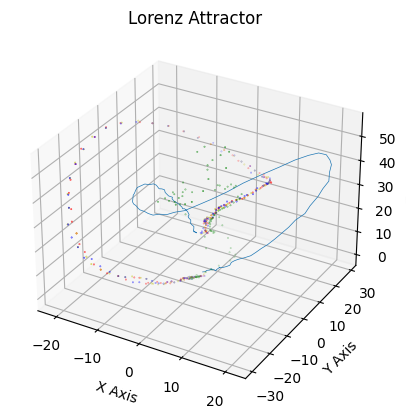

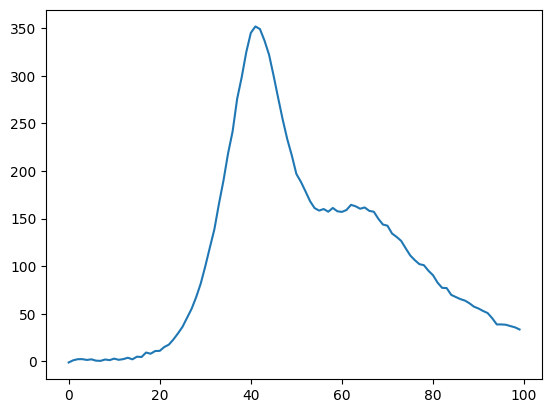

In [70]:
## 3D Plot

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

# Data for AGSF
agsf0 = agsf_out[0][:, :, 0]
ax.scatter3D(*agsf0.T, s=0.1, c='b');

agsf1 = agsf_out[0][:, :, 1]
ax.scatter3D(*agsf1.T, s=0.1, c='r');

agsf2 = agsf_out[0][:, :, 2]
ax.scatter3D(*agsf2.T, s=0.1, c='y');

# Data for BPF
ax.scatter3D(*bpf_mean.T, s=0.1, c='g');

ax1 = plt.figure().add_subplot()

ax1.plot(ys)

plt.show()

## Tabular outputs

In [ ]:
ekf_armse = np.mean(ekf_rmse)
ekf_atime = np.mean(ekf_time)
# gsf_armse = np.mean(gsf_rmse)
# gsf_atime = np.mean(gsf_time)
agsf_armse = np.mean(agsf_rmse)
agsf_atime = np.mean(agsf_time)
bpf_armse = np.mean(bpf_rmse)
bpf_atime = np.mean(bpf_time)

ekf_tab_out = '{:10.2f}±{:10.2f}'.format(ekf_armse, np.std(ekf_rmse))
#gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, np.std(gsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, np.std(agsf_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, np.std(bpf_rmse))

ekf_tab_out1 = '{:10.2f}±{:10.2f}'.format(ekf_atime, np.std(ekf_time))
#gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, np.std(gsf_time))
agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, np.std(agsf_time))
bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, np.std(bpf_time))

df = pd.DataFrame(columns = [' ','ARMSE','time(s)'])
df[' '] = ['EKF', 'AGSF', 'BPF']
df['ARMSE'] = [ekf_tab_out, agsf_tab_out, bpf_tab_out]
df['time(s)'] = [ekf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))  
df

\begin{tabular}{lll}
\toprule
     &                 ARMSE &               time(s) \\
\midrule
 EKF &        nan±       nan &       2.34±      0.04 \\
AGSF &      16.29±      6.18 &      20.89±      1.05 \\
 BPF &      17.11±      6.58 &      88.35±      1.67 \\
\bottomrule
\end{tabular}



,,ARMSE,time(s)
0,EKF,nan± nan,2.34± 0.04
1,AGSF,16.29± 6.18,20.89± 1.05
2,BPF,17.11± 6.58,88.35± 1.67
